In [1]:
import network
from heat_equation.trainer import DGMTrainer, DGMTrainer_2D
from heat_equation.visualize import *
from heat_equation.data_sampling import *
from heat_equation.utility_functions import *

# Deep Galerkin Method with Poisson Equation in 1D (Time Dependent)

In [2]:
lx_1d = 2.0
T_max = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1000
N_IC = 600
N_BC =300

## Functions to implement the internal and boundary conditions

## Data Preparation

In [3]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
x_int, t_int = generate_domain_points(N_INT, bounds_1d, T_max)
f_tx = source_term_fn_1D(t_int, x_int, ALPHA).to(device)
interior_data_1d = (t_int, x_int, f_tx)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
x_ic = generate_ic_points(N_IC, bounds_1d)
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_1D(x_ic).to(device)
ic_data_1d = (t_ic, x_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
x_bc = generate_boundary_points(N_BC, bounds_1d)
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_1D(t_bc, x_bc).to(device)
bc_data_1d = (t_bc, x_bc, u_bc)

## Visualizing the Sampled data

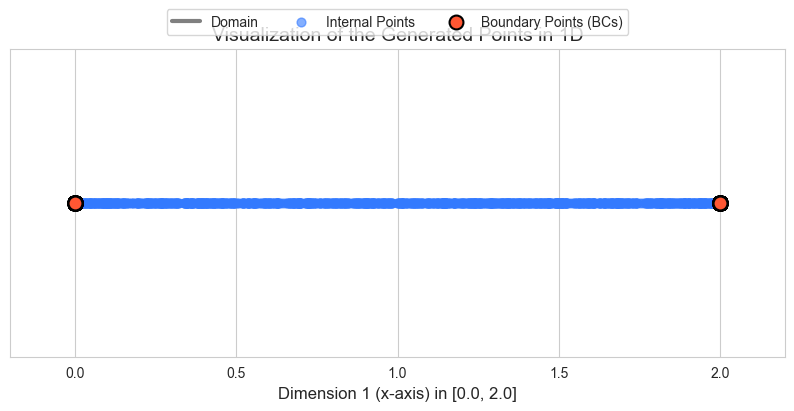

In [4]:
visualize_points_1d(x_int,x_bc, bounds_1d)

## Neural Network initialization

In [5]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 5500

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)

trainer = DGMTrainer(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [6]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data_1d,
    ic_data=ic_data_1d,
    bc_data=bc_data_1d,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 1000, IC: 600, BC: 300 points.
Epoch 100/5500 | Total Loss: 1.0773 | L_pde: 0.0427 | L_ic: 0.0109 | L_bc: 0.0098
Epoch 200/5500 | Total Loss: 0.2616 | L_pde: 0.0127 | L_ic: 0.0028 | L_bc: 0.0021
Epoch 300/5500 | Total Loss: 0.0730 | L_pde: 0.0078 | L_ic: 0.0008 | L_bc: 0.0005
Epoch 400/5500 | Total Loss: 0.0266 | L_pde: 0.0041 | L_ic: 0.0003 | L_bc: 0.0002
Epoch 500/5500 | Total Loss: 0.0361 | L_pde: 0.0075 | L_ic: 0.0003 | L_bc: 0.0003
Epoch 600/5500 | Total Loss: 0.0069 | L_pde: 0.0016 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 700/5500 | Total Loss: 0.0039 | L_pde: 0.0011 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 800/5500 | Total Loss: 0.0024 | L_pde: 0.0007 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 900/5500 | Total Loss: 0.0017 | L_pde: 0.0005 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1000/5500 | Total Loss: 0.0012 | L_pde: 0.0004 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1100/5500 | Total Loss: 0.0195 | L_pde: 0.0003 | L_ic: 0.0002 | L_bc: 0.0002
Epoch 1200/5500 | Total Loss:

## Visualization

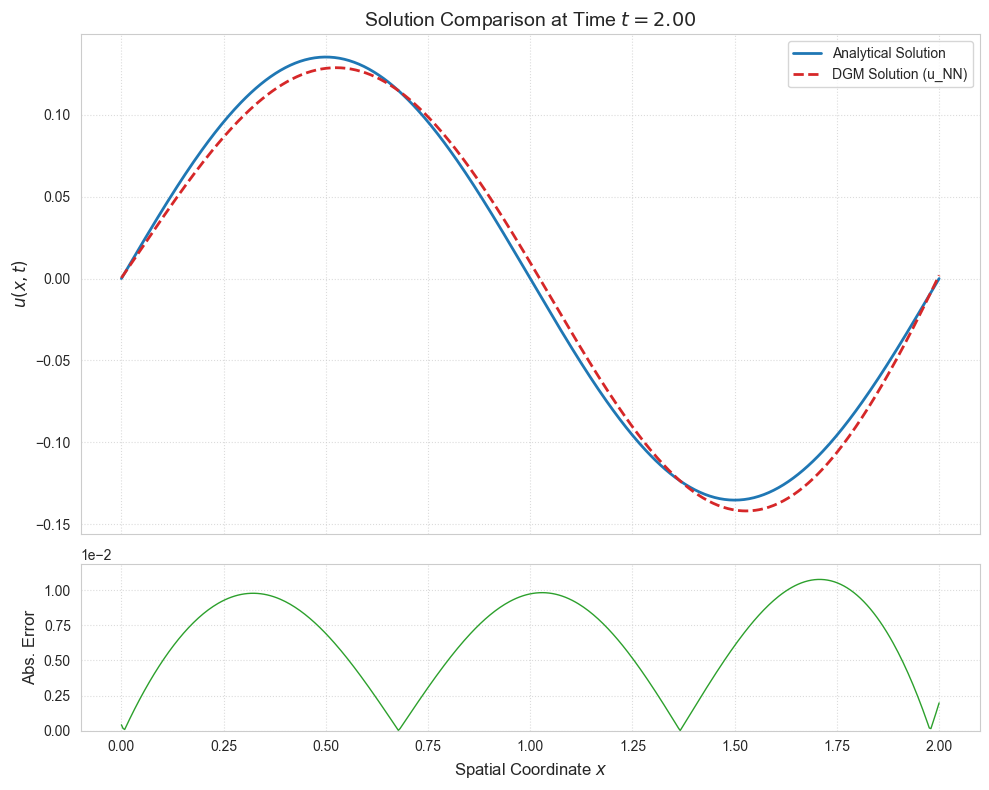

In [7]:
t_test_time = 2.0
visualize_solution_1d(
    model=model,
    domain_bound=lx_1d,
    t_test=t_test_time,
    n_test_points=500
)

# Deep Galerkin Method in 2D

In [8]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1500
N_IC = 800
N_BC =400


## Data Preparation

In [9]:

# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords, t_int = generate_domain_points(N_INT, bounds_2d, T_max)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_txy = source_term_fn_2D(t_int, x_int, y_int, ALPHA).to(device)
interior_data = (t_int, x_int, y_int,  f_txy)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
spatial_coords_ic = generate_ic_points(N_IC, bounds_2d)
x_ic = spatial_coords_ic[:, 0:1]
y_ic = spatial_coords_ic[:, 1:2]
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_2D(x_ic,y_ic).to(device)
ic_data = (t_ic, x_ic, y_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_boundary_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_2D(t_bc, x_bc, y_bc).to(device)
bc_data = (t_bc, x_bc,y_bc, u_bc)

## Visualizing the sampled data

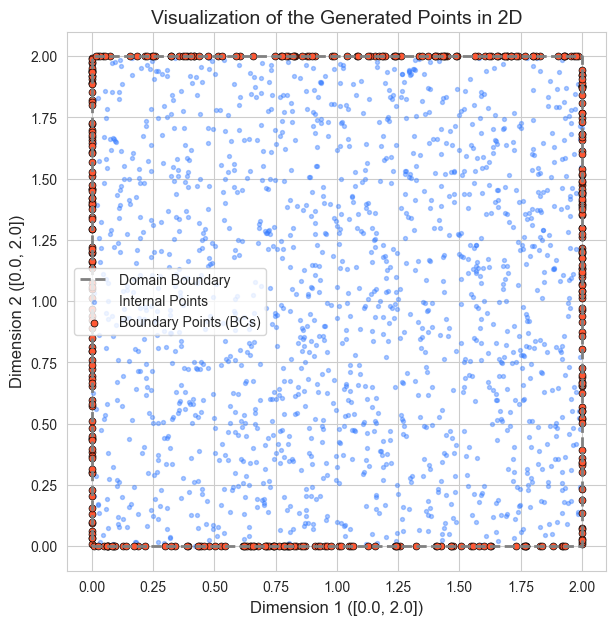

In [10]:
visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Neural Network Initialization

In [11]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 6000

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainer_2D(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [12]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data,
    ic_data=ic_data,
    bc_data=bc_data,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 1500, IC: 800, BC: 400 points.
Epoch 100/6000 | Total Loss: 1.3030 | L_pde: 0.0340 | L_ic: 0.0178 | L_bc: 0.0076
Epoch 200/6000 | Total Loss: 0.3728 | L_pde: 0.0186 | L_ic: 0.0041 | L_bc: 0.0029
Epoch 300/6000 | Total Loss: 0.1720 | L_pde: 0.0108 | L_ic: 0.0018 | L_bc: 0.0015
Epoch 400/6000 | Total Loss: 0.0874 | L_pde: 0.0069 | L_ic: 0.0008 | L_bc: 0.0008
Epoch 500/6000 | Total Loss: 0.0580 | L_pde: 0.0056 | L_ic: 0.0005 | L_bc: 0.0005
Epoch 600/6000 | Total Loss: 0.0351 | L_pde: 0.0039 | L_ic: 0.0003 | L_bc: 0.0003
Epoch 700/6000 | Total Loss: 0.0238 | L_pde: 0.0029 | L_ic: 0.0002 | L_bc: 0.0002
Epoch 800/6000 | Total Loss: 0.0169 | L_pde: 0.0024 | L_ic: 0.0001 | L_bc: 0.0002
Epoch 900/6000 | Total Loss: 0.0121 | L_pde: 0.0020 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1000/6000 | Total Loss: 0.0095 | L_pde: 0.0018 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1100/6000 | Total Loss: 0.0070 | L_pde: 0.0014 | L_ic: 0.0000 | L_bc: 0.0001
Epoch 1200/6000 | Total Loss:

## Visualization

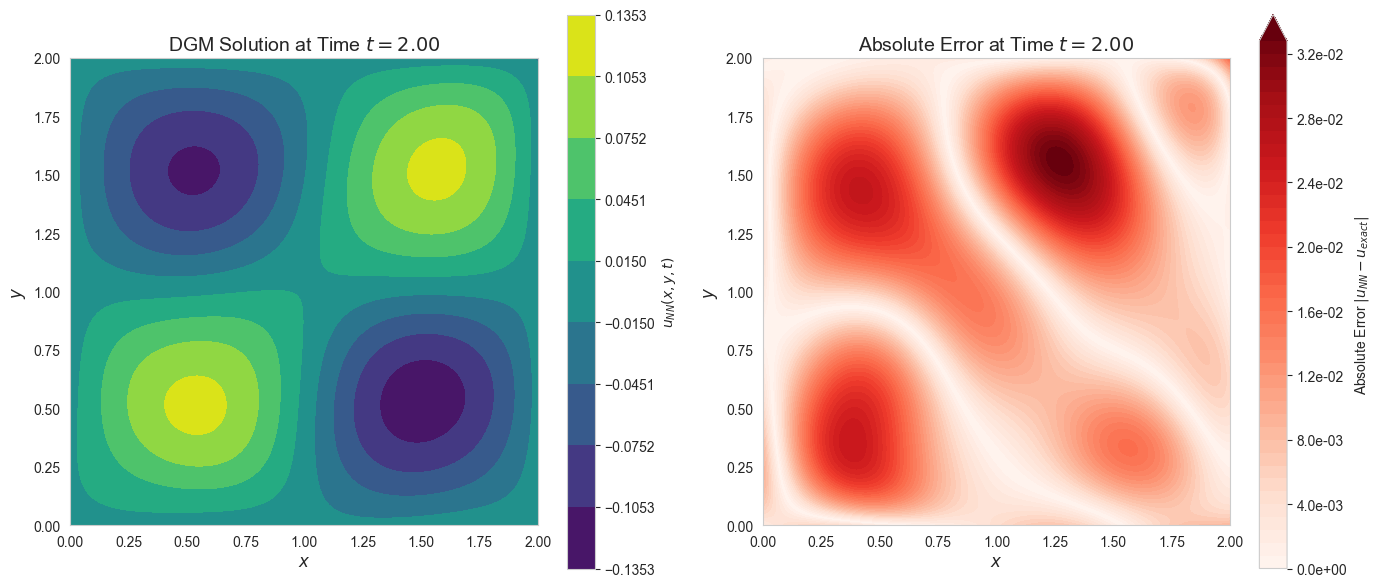

In [13]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)

/Users/abhijithsai/PycharmProjects/deep_galerkin_methods_v2/heat_equation/visualize.py:325: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


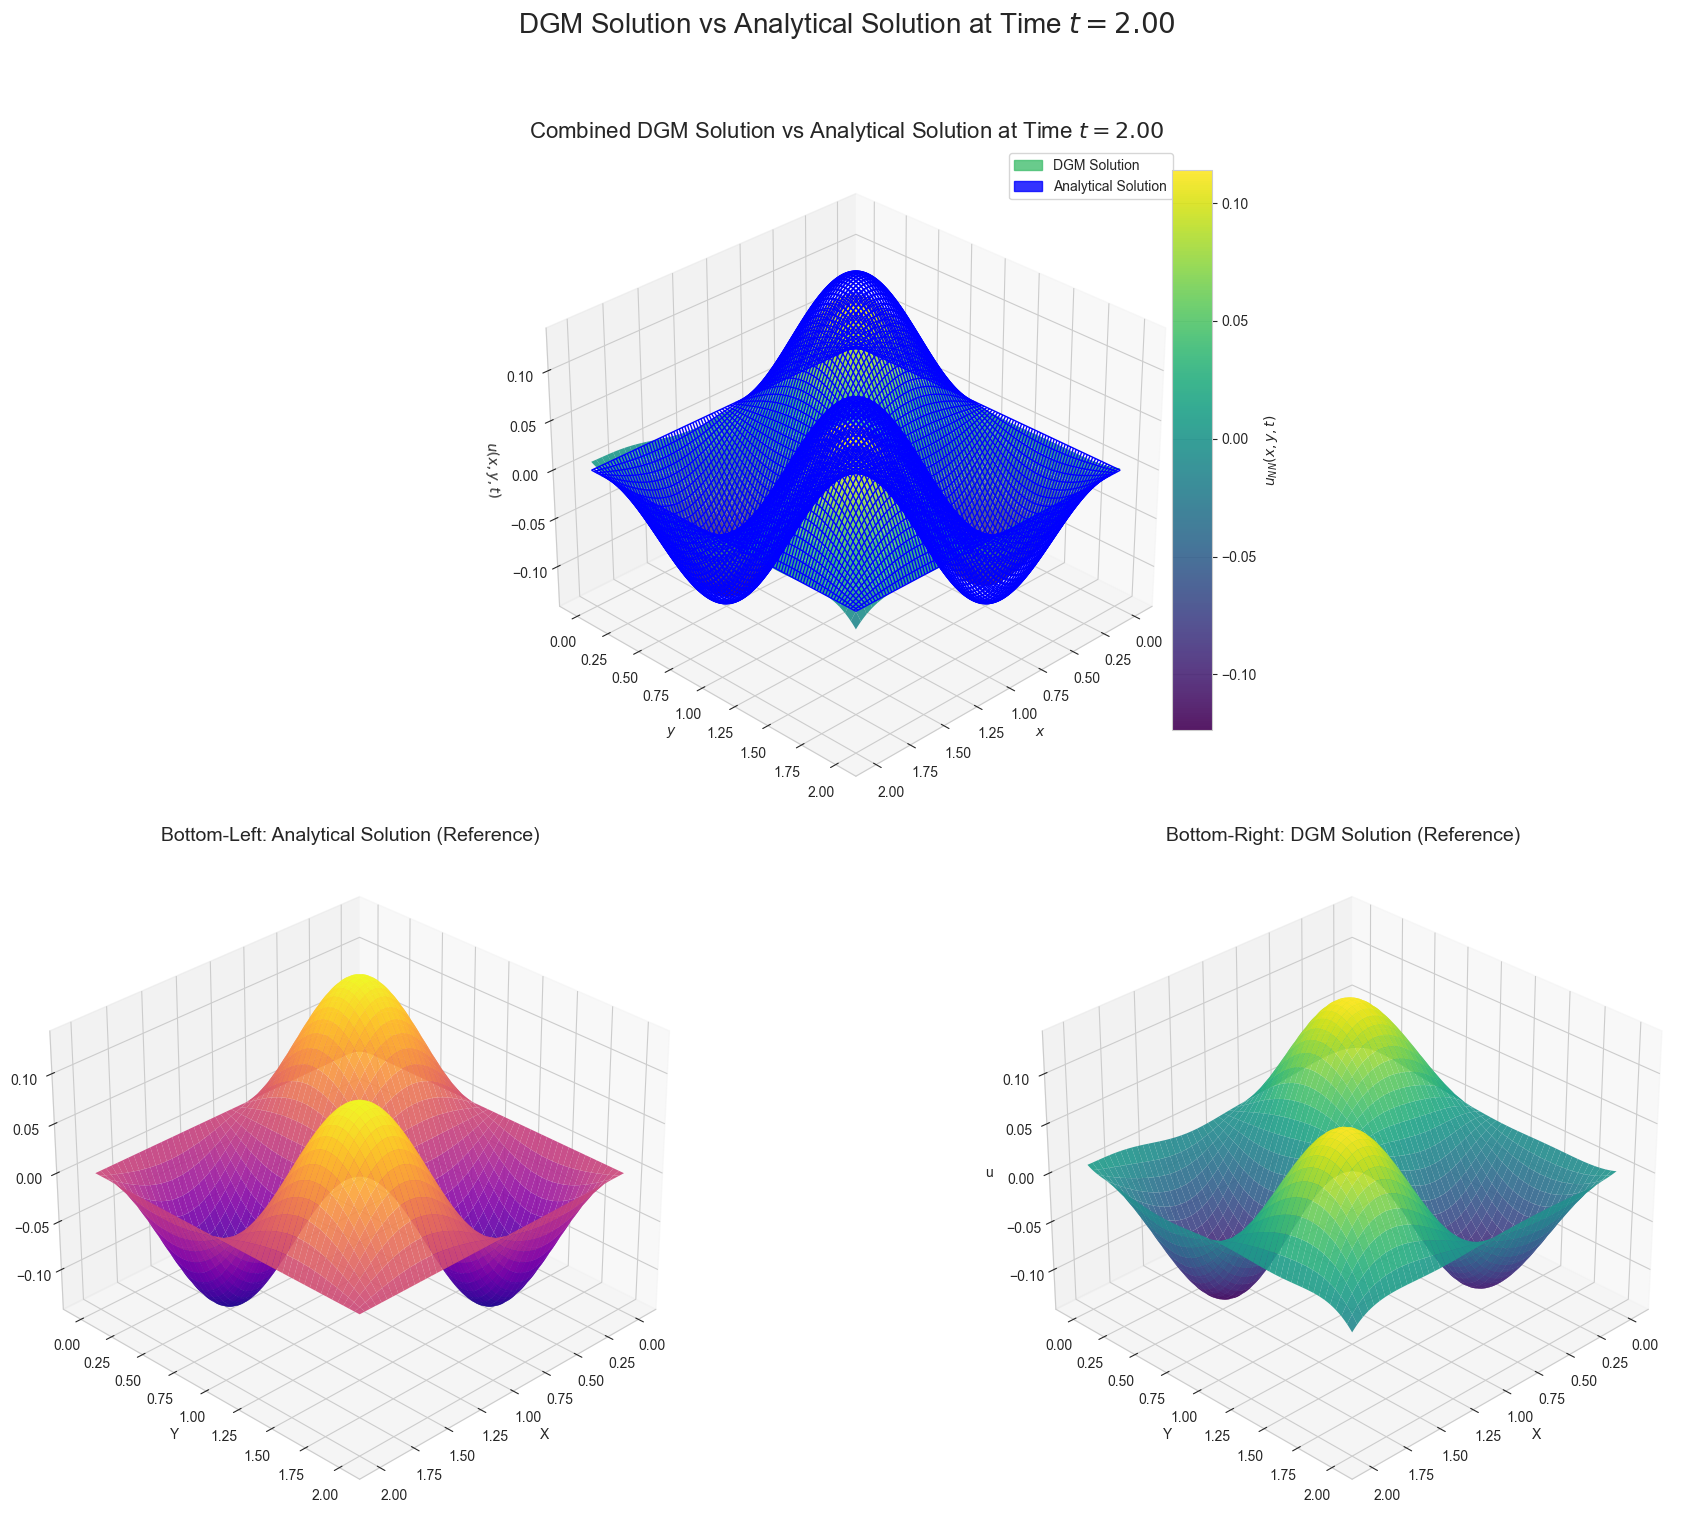

In [14]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)